# PRÁCTICA 2 - Evaluación de la relevancia de variables de entrada

In [433]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from pandas.plotting import table 

%matplotlib inline

x1 = np.random.choice([False, True], size=(100,)).astype(int)
x2 = np.random.choice([False, True], size=(100,)).astype(int)
x3 = np.random.choice([False, True], size=(100,)).astype(int)
x4 = np.logical_xor(x2, x3).astype(int)
x5 = np.random.choice([False, True], size=(100,)).astype(int)
y = np.logical_xor.reduce((x1, x2, x3)).astype(int)

x1 = x1.reshape(len(x1), 1)
x2 = x2.reshape(len(x2), 1)
x3 = x3.reshape(len(x3), 1)
x4 = x4.reshape(len(x4), 1)
x5 = x5.reshape(len(x5), 1)

X = pd.DataFrame(np.concatenate((x1, x2, x3, x4, x5), axis=1), columns=["x1", "x2", "x3", "x4", "x5"])
X

,x1,x2,x3,x4,x5
0,0,0,1,1,0
1,1,0,0,0,1
2,1,0,1,1,0
3,0,1,1,0,1
4,1,0,1,1,1
...,...,...,...,...,...
95,1,1,1,0,1
96,0,0,1,1,1
97,0,0,0,0,0
98,0,1,0,1,1


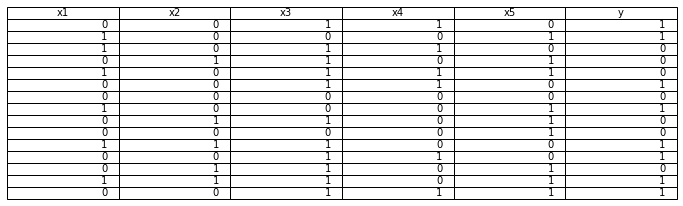

In [434]:
XY = X.copy()
XY['y'] = y.tolist()
df = pd.DataFrame(XY)
#set fig size
fig, ax = plt.subplots(figsize=(12, 3)) 
# no axes
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
# no frame
ax.set_frame_on(False)  
# plot table
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values[0:15],colLabels=df.columns,loc="center")
# save the result
plt.savefig('dataset.png')        

In [435]:
X.mean(axis=0)


x1    0.41
x2    0.47
x3    0.61
x4    0.48
x5    0.47
dtype: float64

In [436]:
X.var(axis=0)

x1    0.244343
x2    0.251616
x3    0.240303
x4    0.252121
x5    0.251616
dtype: float64

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Correlación

          x1        x2        x3        x4        x5
x1  1.000000  0.029738 -0.042102  0.013023  0.111214
x2  0.029738  1.000000  0.054635 -0.222980  0.116821
x3 -0.042102  0.054635  1.000000  0.070584 -0.027523
x4  0.013023 -0.222980  0.070584  1.000000 -0.062563
x5  0.111214  0.116821 -0.027523 -0.062563  1.000000
Number of features to be extracted:  0


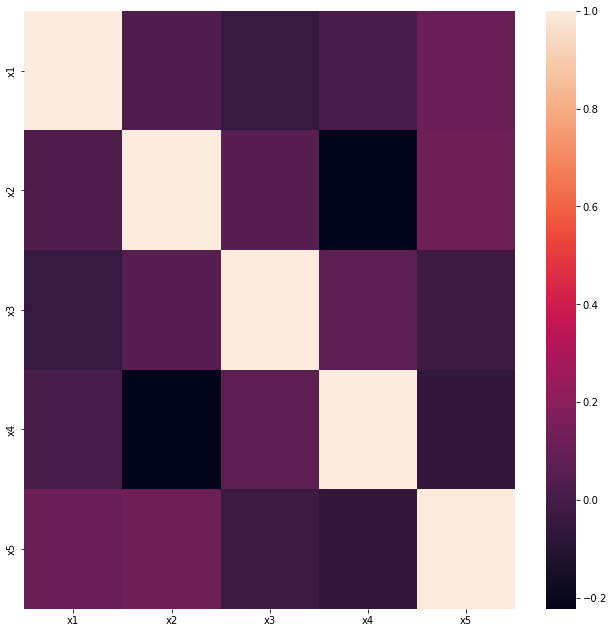

In [438]:
X_corr = X.copy()

def correlation(data, threshold):
    col_corr = set() # all correlated columns.
    corr_mat = data.corr(method='pearson')
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(11,11)
    sns.heatmap(corr_mat)
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (corr_mat.iloc[i,j])> threshold:	
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    print (corr_mat)
    return col_corr
corr_feats = correlation(X_corr, 0.8)
print ('Number of features to be extracted: ',  len(corr_feats)) # Number of features to be extracted


## Información mutua

In [439]:
X_mut = X.copy()
y_mut = y.copy()

mi = mutual_info_classif(X_mut.fillna(0), y_mut)
mi = pd.Series(mi)
mi.index = X_mut.columns # add var names
mi.sort_values(ascending=False) # sorting
# top k=3 features
sel = SelectKBest(mutual_info_classif, k=3).fit(X_mut.fillna(0), y_mut)
print(X_mut.columns[sel.get_support()])

Index(['x2', 'x3', 'x4'], dtype='object')


In [440]:
mi


x1    0.076091
x2    0.025157
x3    0.046575
x4    0.000000
x5    0.000000
dtype: float64

## Test de Fisher

In [441]:
X_fis = X.copy()
y_fis = y.copy()

# Fisher Test
f_score = chi2(X_fis.fillna(0), y_fis)
p_values = pd.Series(f_score[1])
p_values.index = X_fis.columns
p_values.sort_values(ascending=True, inplace=True)
print (p_values)

x4    0.195830
x5    0.239632
x2    0.553629
x3    0.776181
x1    0.776186
dtype: float64


## ANOVA

In [442]:
X_anova = X.copy()
y_anova = y.copy()

univariate = f_classif(X_anova.fillna(0), y_anova)
univariate = pd.Series(univariate[1]) # p-value
univariate.index = X_anova.columns
univariate.sort_values(ascending=False, inplace=True)
print (univariate)

x1    0.714667
x3    0.652885
x2    0.420973
x5    0.108387
x4    0.074139
dtype: float32


## ROC-AUC

In [443]:
X_roc = X.copy()
y_roc = y.copy()

roc_vals = []
for feat in X_roc.columns:
 	clf = DecisionTreeClassifier()
 	clf.fit(X_roc[feat].fillna(0).to_frame(), y_roc)
 	y_scored = clf.predict_proba(X_roc[feat].fillna(0).to_frame())
 	roc_vals.append(roc_auc_score(y_roc, y_scored[:,1]))
roc_vals = pd.Series(roc_vals)
roc_vals.index = X_roc.columns
selected_feats = roc_vals[roc_vals>0.5]
print (selected_feats)

x1    0.518207
x2    0.540616
x3    0.522209
x4    0.589636
x5    0.580632
dtype: float64


## Markov Blanket

In [445]:
df_mb = pd.DataFrame(XY)
# Import the algorithm. PPIMBC is for classification and PPIMBR is for regression
from PyImpetus import PPIMBC, PPIMBR
# Initialize the PyImpetus object
model = PPIMBC(model=SVC(random_state=27, class_weight="balanced"), p_val_thresh=0.20, num_simul=30 , simul_size=0.4, simul_type=1, sig_test_type="non-parametric", cv=5, random_state=27, n_jobs=-1, verbose=2)
# The fit_transform function is a wrapper for the fit and transform functions, individually.
# The fit function finds the MB for given data while transform function provides the pruned form of the dataset
df_mb = model.fit_transform(df_mb.drop("y", axis=1), df_mb["y"].values)

# Check out the MB
print(model.MB)
# Check out the feature importance scores for the selected feature subset
print(model.feat_imp_scores)

# Get a plot of the feature importance scores
model.feature_importance()

Progress bar: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

[]
[]


ValueError: min() arg is an empty sequence

## Envoltura con Forward selection

In [ ]:
X_train_wrap, X_test_wrap = X_train.copy(), X_test.copy()
y_train_wrap, y_test_wrap = y_train.copy(), y_test.copy()

clf_sfs = SFS(RandomForestClassifier(n_jobs=4), 
 				k_features=2, 
 				forward=True,
 				floating=False,
 				verbose=2,
 				scoring='roc_auc', 
 				cv=3 )
clf_sfs = clf_sfs.fit(np.array(X_train_wrap.fillna(0)), y_train_wrap)
 
selected_feats = X_train_wrap.columns[list(clf_sfs.k_feature_idx_)]

print (selected_feats)
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train_wrap, y_train_wrap)
print('Train set')
pred = rf.predict_proba(X_train_wrap)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train_wrap, pred[:,1])))
print('Test set')
pred = rf.predict_proba(X_test_wrap)
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test_wrap, pred[:,1])))

# ANÁLISIS DE COMPONENTES PRINCIPALES

In [ ]:
X_train_pca, X_test_pca = X_train.copy(), X_test.copy()
y_train_pca, y_test_pca = y_train.copy(), y_test.copy()

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(X_train_pca)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = X_train_pca.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)


In [ ]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(X_train_pca.columns)), X_train_pca.columns)
plt.xticks(range(len(X_train_pca.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_train_pca.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(X_train_pca.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(X_train_pca.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');